# Sequence To Sequence (Seq2seq), Machine Translation

In [1]:
import os
import re
import time
import math
import random
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Set Configs

In [3]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

LR = 0.01
HIDDEN_DIM = 256
DROPOUT = 0.1
N_EPOCHS = 75000
TEACHER_FORCING_ratio = 0.5

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Set Helpers

In [5]:
class Language:
    
    def __init__(self, name):
        super(Language, self).__init__()
        
        self.name = name
        self.word2count = {}
        self.word2index = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
    
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [7]:
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'([.!?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    
    return s

In [8]:
def read_languages(lang1, lang2, reverse=False):
    print('Reading lines...')
    
    # read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    # split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # reverse pairs, make language instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Language(lang2)
        target_lang = Language(lang1)
    else:
        input_lang = Language(lang1)
        target_lang = Language(lang2)
    
    return input_lang, target_lang, pairs

In [9]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

In [10]:
def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [11]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, target_lang, pairs = read_languages(lang1, lang2, reverse)
    
    print('Read %s sentence pairs.' % len(pairs))
    pairs = filter_pairs(pairs)
    print('Trimmed to %s sentence pairs.' % len(pairs))
    
    print('Counting words...')
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        target_lang.add_sentence(pair[1])
        
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(target_lang.name, target_lang.n_words)
    
    return input_lang, target_lang, pairs

In [12]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [13]:
def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [14]:
def tensor_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(target_lang, pair[1])
    
    return (input_tensor, target_tensor)

In [15]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' %(m, s)

In [16]:
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [17]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return ret[n - 1:] / n

In [18]:
def show_plot_evaluation(points, n):
    
    points = moving_average(points, n)
    
    plt.figure(figsize=(10, 6))
    plt.plot(points)
    plt.savefig('./images/plot_evaluation_of_network.png')
    plt.show()

## Pre-process Data

In [19]:
input_lang, target_lang, pairs = prepare_data('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs.
Trimmed to 10599 sentence pairs.
Counting words...
Counted words:
fra 4345
eng 2803


## Build [Seq2seq](https://arxiv.org/pdf/1409.3215.pdf) Network

In [20]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_dim):
        super(Encoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(input_size, hidden_dim)
        self.gru_layer = nn.GRU(hidden_dim, hidden_dim)
        
    def init_hidden(self):
        hidden = torch.zeros(1, 1, self.hidden_dim, device=device)
        return hidden
    
    def forward(self, x, hidden):
        
        x = x.long()
        embeds = self.embedding_layer(x).view(1, 1, -1)
        gru_out, hidden = self.gru_layer(embeds, hidden)
        
        return gru_out, hidden

In [21]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_dim, output_size):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(output_size, hidden_dim)
        self.gru_layer = nn.GRU(hidden_dim, hidden_dim)
        self.fc_layer = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        hidden = torch.zeros(1, 1, self.hidden_dim, device=device)
        return hidden
    
    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        x = x.long()
        embeds = self.embedding_layer(x).view(1, 1, -1)
        gru_out, hidden = self.gru_layer(F.relu(embeds), hidden)
        gru_out = self.softmax(self.fc_layer(gru_out[0]))
        
        return gru_out, hidden

## Build [Attention](https://arxiv.org/pdf/1706.03762.pdf) Network

In [22]:
class AttentionDecoder(nn.Module):
    
    def __init__(self, hidden_dim, output_size, dropout=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.dropout = dropout
        self.max_length = max_length
        
        self.embedding_layer = nn.Embedding(self.output_size, self.hidden_dim)
        self.attention_layer = nn.Linear(self.hidden_dim * 2, self.max_length)
        self.attention_combine_layer = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.gru_layer = nn.GRU(self.hidden_dim, self.hidden_dim)
        self.fc_layer = nn.Linear(self.hidden_dim, self.output_size)
    
    def init_hidden(self):
        hidden = torch.zeros(1, 1, self.hidden_dim, device=device)
        return hidden
        
    def forward(self, x, hidden, encoder_outputs):
        
        x = x.long()
        embeds = self.embedding_layer(x).view(1, 1, -1)
        embeds = self.dropout(embeds)
        
        attention_weights = F.softmax(self.attention_layer(torch.cat((embeds[0], hidden[0]), 1)), dim=1)
        attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                                      encoder_outputs.unsqueeze(0))
        
        attention_out = torch.cat((embeds[0], attention_applied[0]), 1)
        attention_out = self.attention_combine_layer(attention_out).unsqueeze(0)
        
        attention_out = F.relu(attention_out)
        gru_out, hidden = self.gru_layer(attention_out, hidden)
        
        gru_out = F.log_softmax(self.fc_layer(gru_out[0]), dim=1)
        
        return gru_out, hidden, attention_weights

#### Initialize Seq2seq Network

In [23]:
encoder = Encoder(input_lang.n_words, HIDDEN_DIM)
encoder.to(device)

Encoder(
  (embedding_layer): Embedding(4345, 256)
  (gru_layer): GRU(256, 256)
)

In [24]:
decoder = Decoder(HIDDEN_DIM, target_lang.n_words)
decoder.to(device)

Decoder(
  (embedding_layer): Embedding(2803, 256)
  (gru_layer): GRU(256, 256)
  (fc_layer): Linear(in_features=256, out_features=2803, bias=True)
  (softmax): LogSoftmax()
)

#### Initialize Attention Network

In [25]:
attention_decoder = AttentionDecoder(HIDDEN_DIM, target_lang.n_words, dropout=DROPOUT)
attention_decoder.to(device)

AttentionDecoder(
  (embedding_layer): Embedding(2803, 256)
  (attention_layer): Linear(in_features=512, out_features=10, bias=True)
  (attention_combine_layer): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru_layer): GRU(256, 256)
  (fc_layer): Linear(in_features=256, out_features=2803, bias=True)
)

## Set Loss Function

In [26]:
nll_loss = nn.NLLLoss()

## Set Optimizer

In [27]:
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=LR)

def init_decoder_optimizer(decoder): return torch.optim.SGD(decoder.parameters(), lr=LR)
decoder_optimizer = init_decoder_optimizer(decoder)
attention_decoder_optimizer = init_decoder_optimizer(attention_decoder)

## Train Seq2seq Network

In [28]:
tick = time.time()
losses_history = []
loss_total_print = 0
loss_total_plot = 0

print_every = 5000
plot_every = 100

training_pairs = [tensor_from_pair(random.choice(pairs)) for _ in range(N_EPOCHS)]

print('Training the network...')
for epoch in range(1, N_EPOCHS+1):
    
    training_pair = training_pairs[epoch - 1]
    
    input_seq = training_pair[0]
    input_length = input_seq.size(0)
    
    target_seq = training_pair[1]
    target_length = target_seq.size(0)
    
    encoder_hidden = encoder.init_hidden()
    
    encoder_optimizer.zero_grad()
    attention_decoder_optimizer.zero_grad()
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_seq[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    USE_TEACHER_FORCING = True if random.random() < TEACHER_FORCING_ratio else False
    
    if USE_TEACHER_FORCING:

        # teacher forcing: feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = attention_decoder(decoder_input, 
                                                                                  decoder_hidden, encoder_outputs)
            decoder_input = target_seq[di] # teacher forcing
            loss += nll_loss(decoder_output, target_seq[di])
    else:
        
        # without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = attention_decoder(decoder_input, 
                                                                                  decoder_hidden, encoder_outputs)
            top_value, top_index = decoder_output.topk(1)
            decoder_input = top_index.squeeze().detach() # detach from history as input                
            loss += nll_loss(decoder_output, target_seq[di])
            
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    encoder_optimizer.step()
    attention_decoder_optimizer.step()
    
    loss = loss.item()
    loss_total_print += loss
    loss_total_plot += loss
    
    if epoch % print_every == 0:
        loss_avg_print = loss_total_print / print_every
        loss_total_print = 0
        print('%d | %d epochs, Average Loss: %.4f, Times Taken: %s' % (epoch, N_EPOCHS, loss_avg_print,
                                                                        time_since(tick, epoch / N_EPOCHS)))
        
    if epoch & plot_every == 0:
        loss_avg_plot = loss_total_plot / plot_every
        losses_history.append(loss_avg_plot)
        loss_total_plot = 0

Training the network...
5000 | 75000 epochs, Average Loss: 20.8322, Times Taken: 1m 14s (- 17m 23s)
10000 | 75000 epochs, Average Loss: 16.8106, Times Taken: 2m 25s (- 15m 45s)
15000 | 75000 epochs, Average Loss: 14.4783, Times Taken: 3m 38s (- 14m 34s)
20000 | 75000 epochs, Average Loss: 12.7815, Times Taken: 4m 52s (- 13m 23s)
25000 | 75000 epochs, Average Loss: 11.2416, Times Taken: 6m 7s (- 12m 15s)
30000 | 75000 epochs, Average Loss: 10.0669, Times Taken: 7m 21s (- 11m 2s)
35000 | 75000 epochs, Average Loss: 8.9463, Times Taken: 8m 36s (- 9m 50s)
40000 | 75000 epochs, Average Loss: 8.1488, Times Taken: 9m 51s (- 8m 37s)
45000 | 75000 epochs, Average Loss: 7.1714, Times Taken: 11m 6s (- 7m 24s)
50000 | 75000 epochs, Average Loss: 6.4137, Times Taken: 12m 22s (- 6m 11s)
55000 | 75000 epochs, Average Loss: 5.6919, Times Taken: 13m 37s (- 4m 57s)
60000 | 75000 epochs, Average Loss: 5.2151, Times Taken: 14m 52s (- 3m 43s)
65000 | 75000 epochs, Average Loss: 5.0109, Times Taken: 16m 7s 

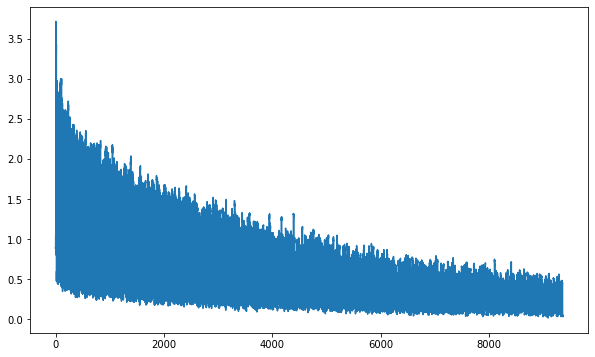

In [29]:
show_plot_evaluation(losses_history, 10)

## Evaluate The Network

In [30]:
def evaluate_network(encoder, decoder, sentence, max_length=MAX_LENGTH):
    
    print('Evaluating the network...')
    with torch.no_grad():
        input_seq = tensor_from_sentence(input_lang, sentence)
        input_length = input_seq.size()[0]
        encoder_hidden = encoder.init_hidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_dim, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_seq[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                        decoder_hidden,
                                                                        encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            top_value, top_index = decoder_output.data.topk(1)
            
            if top_index.item() == EOS_token:
                decoded_words.append('<EOS>')
            else:
                decoded_words.append(target_lang.index2word[top_index.item()])
                
            decoder_input = top_index.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di+1]

In [31]:
def evaluate_network_randomly(encoder, decoder, n_sentences=10):
    for i in range(n_sentences):
        pair = random.choice(pairs)
        print('Input:', pair[0])
        print('Target:', pair[1])
        output_words, attentions = evaluate_network(encoder, decoder, pair[0])
        output_sentences = ' '.join(output_words)
        
        print('Network Output:', output_sentences)
        print('')

In [32]:
evaluate_network_randomly(encoder, attention_decoder)

Input: je ne suis pas du matin .
Target: i m not a morning person .
Evaluating the network...
Network Output: i m not a morning . <EOS> <EOS> . <EOS>

Input: vous le faites comme il faut .
Target: you re doing it right .
Evaluating the network...
Network Output: you re doing it right . <EOS> . <EOS> <EOS>

Input: je ne suis pas triste .
Target: i m not sad .
Evaluating the network...
Network Output: i m not sad . <EOS> . <EOS> <EOS> .

Input: nous en avons presque fini .
Target: we re nearly finished .
Evaluating the network...
Network Output: we re nearly finished . <EOS> . <EOS> . <EOS>

Input: ils collectent des dons pour l eglise .
Target: they are collecting contributions for the church .
Evaluating the network...
Network Output: they are collecting contributions for the inconvenience . <EOS> .

Input: vous etes brillantes .
Target: you re bright .
Evaluating the network...
Network Output: you re bright . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Input: je me rejouis de te revoir .
Tar

## Visualize Network Attention

Evaluating the network...


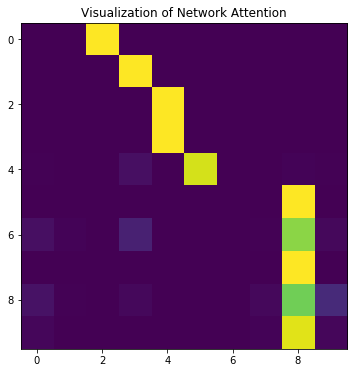

In [33]:
output_words, attentions = evaluate_network(encoder, attention_decoder, 'je suis trop froid .')
plt.figure(figsize=(6, 6))
plt.imshow(attentions.numpy())
plt.title('Visualization of Network Attention')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/visualization_of_network_attention.png')

plt.show()

#### Evaluate & Show The Attention

In [34]:
def show_attention(input_seq, output_words, attentions):
    
    # set up figure with color bar
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    cax = ax.imshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    # set up axes
    ax.set_xticklabels([''] + input_seq.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    # show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig('./images/visualization_of_network_attention_exp.png')
    
    plt.show()

In [35]:
def evaluate_and_show_attention(input_seq):
    output_words, attentions = evaluate_network(encoder, attention_decoder, input_seq)
    print('Input:', input_seq)
    print('Networ Output:', ' '.join(output_words))
    
    show_attention(input_seq, output_words, attentions)

Evaluating the network...
Input: elle a cinq ans de moins que moi .
Networ Output: she s five years younger than me . <EOS> .


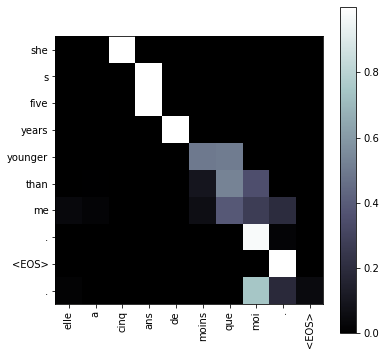

In [36]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

Evaluating the network...
Input: elle est trop petit .
Networ Output: she is too short . <EOS> . <EOS> . <EOS>


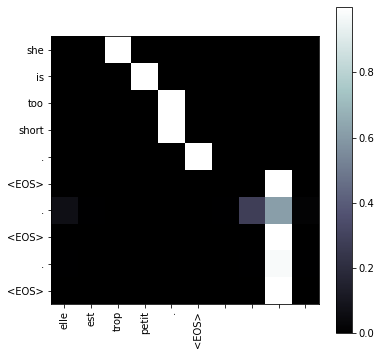

In [37]:
evaluate_and_show_attention("elle est trop petit .")

Evaluating the network...
Input: je ne crains pas de mourir .
Networ Output: i m not scared to die . <EOS> . <EOS>


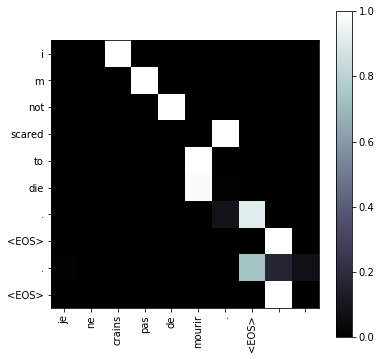

In [38]:
evaluate_and_show_attention("je ne crains pas de mourir .")

Evaluating the network...
Input: c est un jeune directeur plein de talent .
Networ Output: he s a talented young director . <EOS> . <EOS>


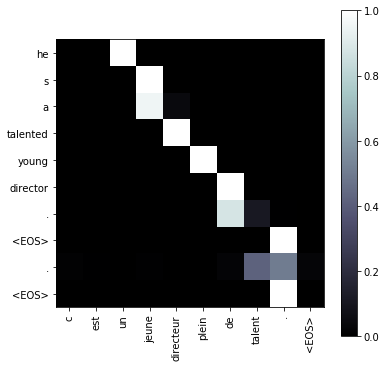

In [39]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

---